## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import random

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, auc, roc_curve, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import RFECV, RFE

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier
import lightgbm as lgb


## Load datasets

In [2]:
train_df = pd.read_csv("aps_failure_training_set.csv", na_values="na")
test_df = pd.read_csv("aps_failure_test_set.csv", na_values="na")

In [4]:
print('Train shape: ',train_df.shape)
print('Test shape: ',test_df.shape)
train_df.head()

Train shape:  (60000, 171)
Test shape:  (16000, 171)


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


## EDA
To understand the distribution of each variable, the variables that contain NaN values, variables with many zeros, categorical variables with high cardinality, etc..
Use pandas profiling to generate a basic report on the input DataFrame.

In [5]:
# Check total numeric and categorical columns
print('Train: ')
train_df.info()
print()
print('Test: ')
test_df.info()

Train: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(1), object(1)
memory usage: 78.3+ MB

Test: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(1), object(1)
memory usage: 20.9+ MB


#### Observation
Both train and test are having 1 categorical column which is Class column.
We need to convert it to numerical values

In [3]:
# Replacing class labels 'neg' --> 0 and 'pos' --> 1
train_df['class'] = train_df['class'].map(lambda x: 1 if x=='pos' else 0)
test_df['class'] = test_df['class'].map(lambda x: 1 if x=='pos' else 0)
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(2)
memory usage: 78.3 MB


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [7]:
# Checking columns with constant value
print('Column with only one value across dataset')
print('Train: ',train_df.columns[train_df.nunique() <= 1])
print('Test: ',test_df.columns[test_df.nunique() <= 1])


Column with only one value across dataset
Train:  Index(['cd_000'], dtype='object')
Test:  Index(['cd_000'], dtype='object')


In [8]:
train_df.cd_000.describe()

count      59324.0
mean     1209600.0
std            0.0
min      1209600.0
25%      1209600.0
50%      1209600.0
75%      1209600.0
max      1209600.0
Name: cd_000, dtype: float64

#### Observation
Column ('cd_000') has a constant value = 1209600 across data set

In [4]:
# Removing column with one unique value
train_df = train_df.drop(['cd_000'],axis=1)
test_df = test_df.drop(['cd_000'],axis=1)
print(train_df.shape, test_df.shape)

(60000, 170) (16000, 170)


In [39]:
# Checking % of missing values in each column #
print(train_df.shape)
train_df.isnull().mean().sort_values(ascending = False)*100

(60000, 170)


br_000    82.106667
bq_000    81.203333
bp_000    79.566667
bo_000    77.221667
ab_000    77.215000
            ...    
cj_000     0.563333
ci_000     0.563333
bt_000     0.278333
aa_000     0.000000
class      0.000000
Length: 170, dtype: float64

In [40]:
print(test_df.shape)
test_df.isnull().mean().sort_values(ascending = False)*100

(16000, 170)


br_000    82.05625
bq_000    81.13125
bp_000    79.50625
bo_000    77.35000
ab_000    77.26875
            ...   
cj_000     0.53750
ci_000     0.53750
bt_000     0.17500
aa_000     0.00000
class      0.00000
Length: 170, dtype: float64

In [5]:
# Checking how many columns with >= 60% missing values
null_percentage = train_df.isnull().sum()/train_df.shape[0]*100
# Below code gives list of columns having more than 60% null
col_to_drop = null_percentage[null_percentage>60].keys()
col_to_drop

Index(['ab_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000',
       'cr_000'],
      dtype='object')

#### Observation
For both train and test data: 8 columns has more than 60% null values

In [6]:
# Dropping features with more than 60% null values
train_removed = train_df.dropna(axis=1, thresh = int(0.4*train_df.shape[0]))
test_removed = test_df.dropna(axis=1, thresh = int(0.4*test_df.shape[0]))
print(train_removed.shape, test_removed.shape)

(60000, 162) (16000, 162)


Text(0, 0.5, '% Missing')

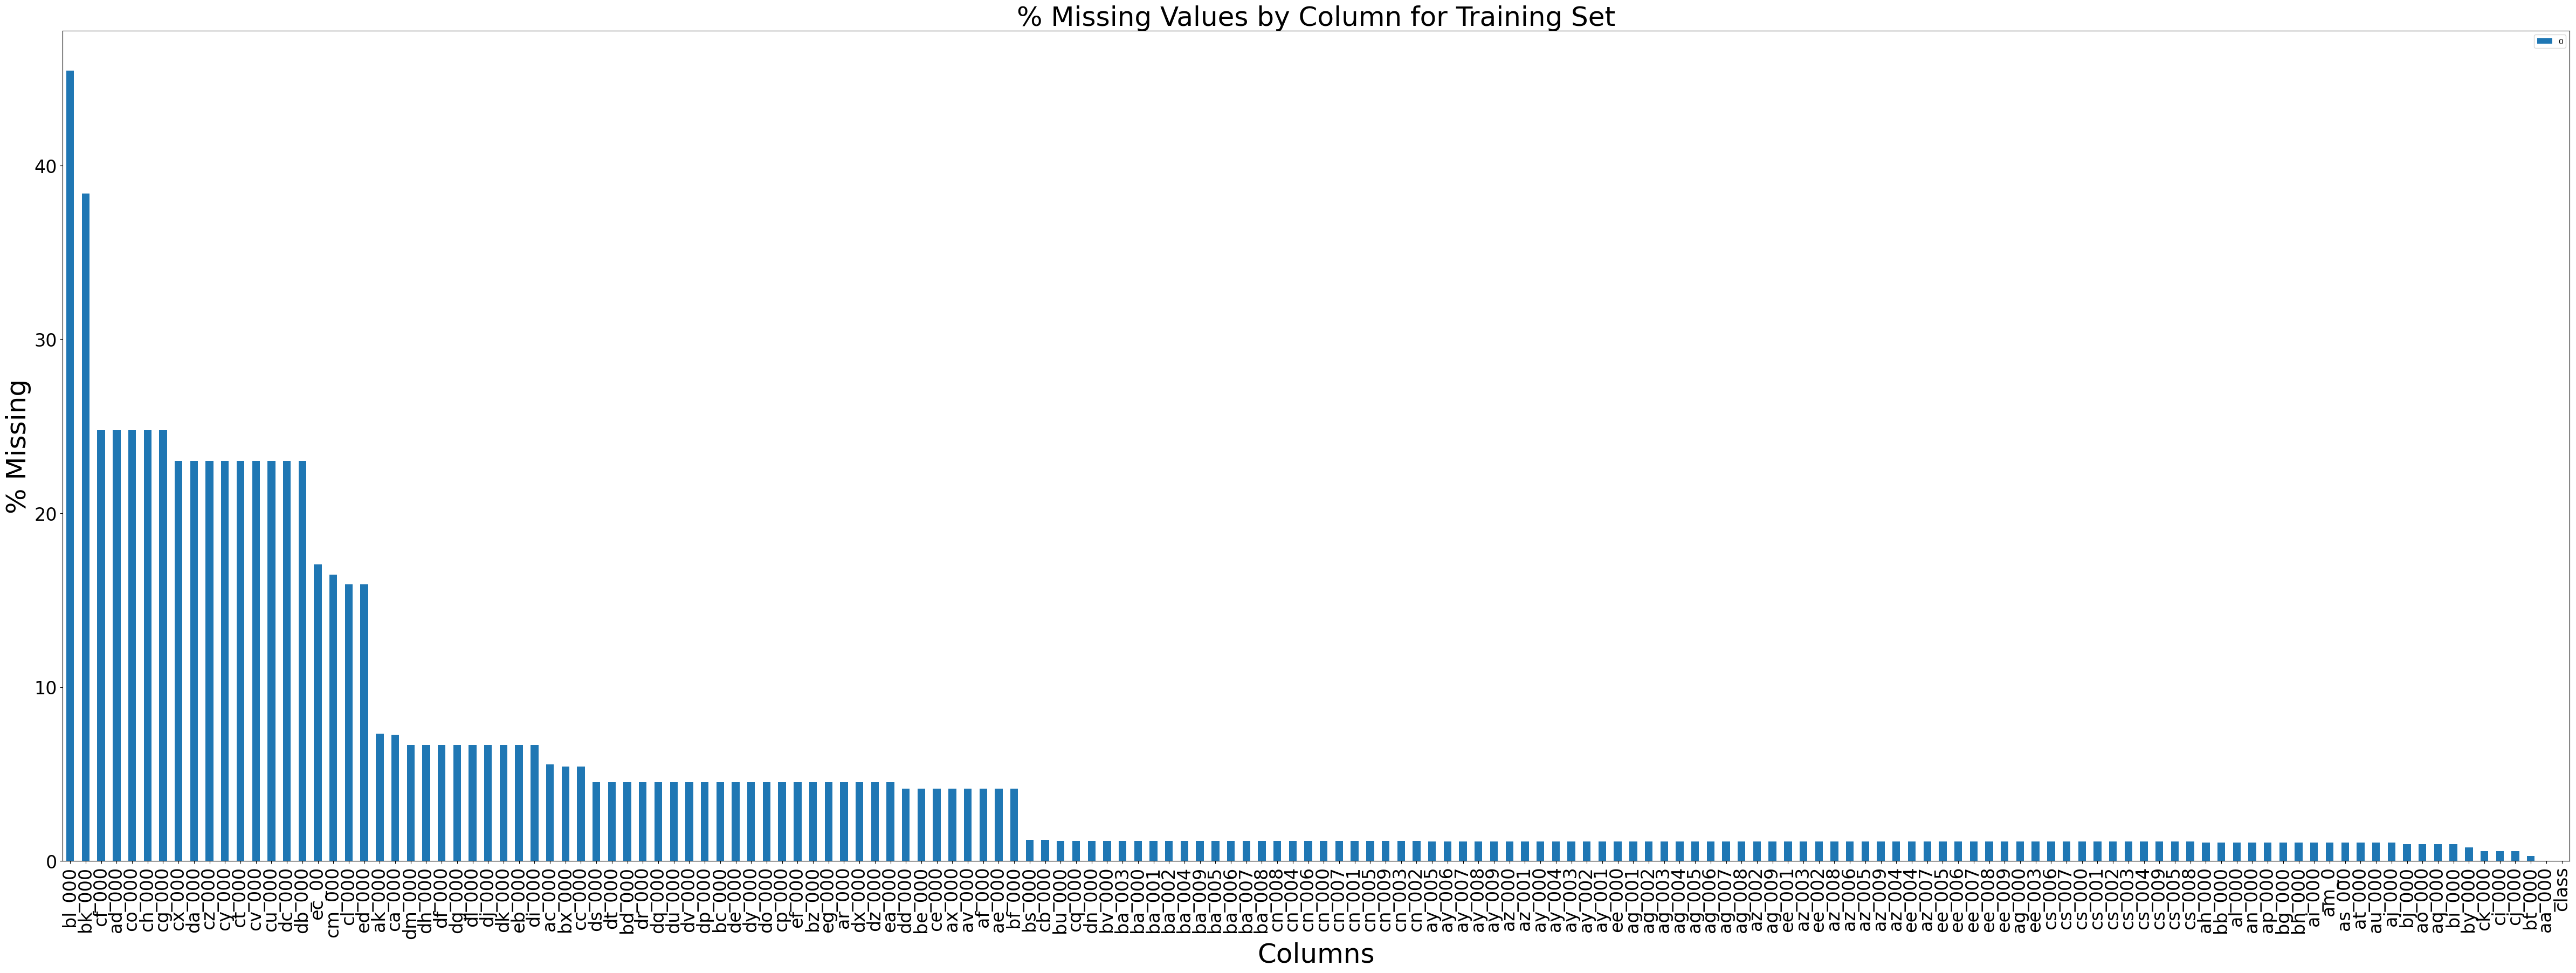

In [70]:
# Checking % of missing values in each column after dropping column with more than 60% null values
null_percentage = train_removed.isnull().sum()/train_removed.shape[0]*100
missing = null_percentage.to_frame().sort_values(by=0, ascending = False)
fig = missing.plot(kind='bar', figsize=(60,20), fontsize=24)
fig.set_title("% Missing Values by Column for Training Set", fontsize=36)
fig.set_xlabel("Columns", fontsize=36)
fig.set_ylabel("% Missing", fontsize=36)

Text(0, 0.5, '% Missing')

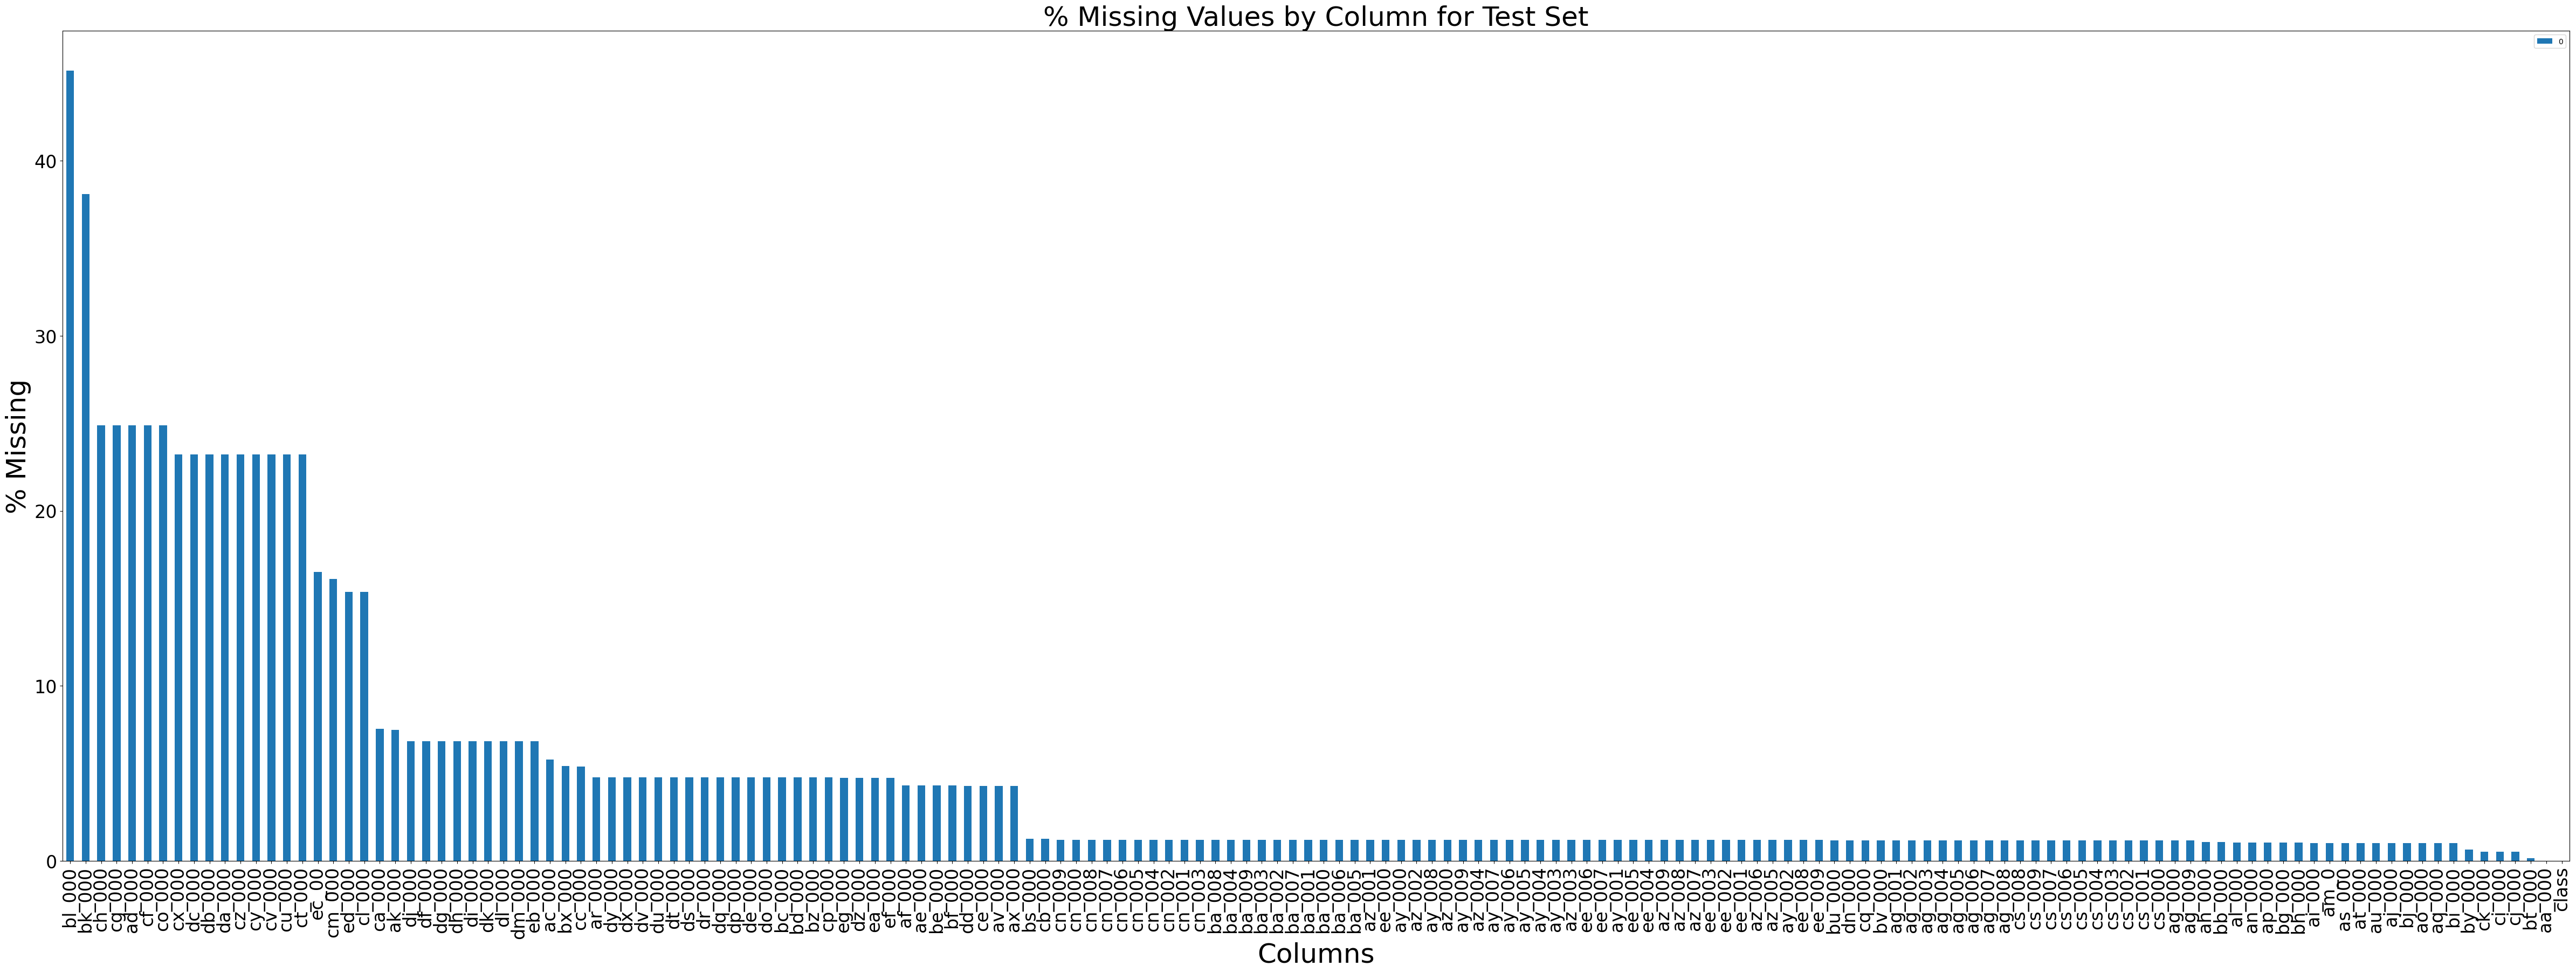

In [71]:
# Checking % of missing values in each column after dropping column with more than 60% null values
null_percentage = test_removed.isnull().sum()/test_removed.shape[0]*100
missing = null_percentage.to_frame().sort_values(by=0, ascending = False)
fig = missing.plot(kind='bar', figsize=(60,20), fontsize=24)
fig.set_title("% Missing Values by Column for Test Set", fontsize=36)
fig.set_xlabel("Columns", fontsize=36)
fig.set_ylabel("% Missing", fontsize=36)

#### Observation
Both train and test data has 162 columns which all having <50% missing values

In [7]:
# Fill null with mean values to complete the train and test/validation dataset
for col in train_removed:
    # Complete missing col with mode
    train_removed[col].fillna(train_removed[col].mean(), inplace = True)


for col in test_removed:
    # Complete missing col with mode
    test_removed[col].fillna(test_removed[col].mean(), inplace = True)

C:\Users\VivoBook\AppData\Local\Temp\ipykernel_13748\1146965885.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_removed[col].fillna(train_removed[col].mean(), inplace = True)
C:\Users\VivoBook\AppData\Local\Temp\ipykernel_13748\1146965885.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed[col].fillna(test_removed[col].mean(), inplace = True)


In [12]:
null_train=train_removed.isnull().mean().sort_values(ascending = False)*100
null_test=test_removed.isnull().mean().sort_values(ascending = False)*100
print('Total of null column train: ',null_train.unique)
print('Total of null column train: ',null_test.unique)

Total of null column train:  <bound method Series.unique of class     0.0
da_000    0.0
cp_000    0.0
cq_000    0.0
cs_000    0.0
         ... 
ba_003    0.0
ba_004    0.0
ba_005    0.0
ba_006    0.0
eg_000    0.0
Length: 162, dtype: float64>
Total of null column train:  <bound method Series.unique of class     0.0
da_000    0.0
cp_000    0.0
cq_000    0.0
cs_000    0.0
         ... 
ba_003    0.0
ba_004    0.0
ba_005    0.0
ba_006    0.0
eg_000    0.0
Length: 162, dtype: float64>


In [78]:
# Overall correlation matrix for Train data
train_removed.corr()

,class,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
class,1.000000,0.536978,-0.026894,-0.000248,0.007222,0.018339,0.012342,0.191058,0.339908,0.432974,...,0.444017,0.428946,0.416125,0.485774,0.415235,0.160169,0.235277,0.115802,0.014566,0.013874
aa_000,0.536978,1.000000,-0.020777,-0.001110,0.046259,0.066789,0.018541,0.142624,0.284759,0.493699,...,0.732465,0.736337,0.715019,0.724412,0.724157,0.603875,0.469873,0.247075,0.014128,0.026386
ac_000,-0.026894,-0.020777,1.000000,-0.002285,-0.004944,-0.010270,0.017524,-0.000671,-0.008976,-0.023478,...,-0.009280,-0.005859,-0.007236,-0.006898,-0.014152,-0.019008,0.011781,0.019416,-0.006165,0.014228
ad_000,-0.000248,-0.001110,-0.002285,1.000000,-0.000209,-0.000257,-0.000047,-0.000055,-0.000119,-0.000276,...,-0.001015,-0.001057,-0.001046,-0.000848,-0.000862,-0.000518,-0.000932,-0.000578,-0.000095,-0.000114
ae_000,0.007222,0.046259,-0.004944,-0.000209,1.000000,0.823108,-0.000428,-0.000589,0.003214,0.024237,...,0.012989,0.019364,0.013754,0.028607,0.063056,0.037821,-0.008457,-0.006774,0.070835,0.041685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee_007,0.160169,0.603875,-0.019008,-0.000518,0.037821,0.050743,0.000307,0.044161,0.182666,0.505081,...,0.454833,0.446803,0.437682,0.379892,0.545929,1.000000,0.224938,0.061478,-0.000498,0.001841
ee_008,0.235277,0.469873,0.011781,-0.000932,-0.008457,-0.010884,-0.000823,0.004875,0.009449,0.021131,...,0.453811,0.481392,0.459517,0.406920,0.373871,0.224938,1.000000,0.710056,-0.005422,-0.002200
ee_009,0.115802,0.247075,0.019416,-0.000578,-0.006774,-0.008442,-0.001230,-0.004307,-0.009481,-0.019292,...,0.228248,0.239302,0.224638,0.190667,0.163792,0.061478,0.710056,1.000000,-0.003256,-0.000750
ef_000,0.014566,0.014128,-0.006165,-0.000095,0.070835,0.106271,-0.000072,0.002032,0.007393,0.013960,...,0.005132,0.013148,0.004479,0.033649,0.005946,-0.000498,-0.005422,-0.003256,1.000000,0.282184


## Feature Selection
feature selection is the process of selecting a subset of relevant features for use in model construction.
Feature selection methods can be used to identify and remove unneeded, irrelevant and redundant attributes from data that do not contribute to the accuracy of a predictive model.
Fewer attributes is desirable because it reduces the complexity of the model


#### Feature selection method 1 : Correlation Matrix

In [8]:
# Feature Correlation with Class Feature
cor_target = abs(train_removed.corr()["class"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>=0.4]
print(relevant_features.sort_values(ascending=False))


class     1.000000
ci_000    0.550555
aa_000    0.536978
bt_000    0.534525
bb_000    0.531639
bv_000    0.530241
bu_000    0.530241
cq_000    0.530241
aq_000    0.520538
bj_000    0.514769
ah_000    0.513857
an_000    0.513102
cc_000    0.512608
bg_000    0.511639
ao_000    0.509517
bx_000    0.505315
ap_000    0.504655
by_000    0.500048
bh_000    0.486708
ee_005    0.485774
dn_000    0.482844
ba_004    0.477714
cn_004    0.473741
ck_000    0.464379
ba_003    0.459335
ba_005    0.451409
ag_005    0.448148
ee_002    0.444017
cs_005    0.441946
ba_001    0.437650
cs_004    0.437431
ag_003    0.432974
az_005    0.432010
ba_000    0.430622
ee_003    0.428946
ba_002    0.423971
bi_000    0.421027
ee_004    0.416125
ee_006    0.415235
ee_000    0.415214
ay_008    0.409748
cn_003    0.405934
Name: class, dtype: float64


In [13]:
# Select features with high correlated with target
col_to_keep = relevant_features.keys()
col_to_keep

Index(['class', 'aa_000', 'ag_003', 'ag_005', 'ah_000', 'an_000', 'ao_000',
       'ap_000', 'aq_000', 'ay_008', 'az_005', 'ba_000', 'ba_001', 'ba_002',
       'ba_003', 'ba_004', 'ba_005', 'bb_000', 'bg_000', 'bh_000', 'bi_000',
       'bj_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'cc_000',
       'ci_000', 'ck_000', 'cn_003', 'cn_004', 'cq_000', 'cs_004', 'cs_005',
       'dn_000', 'ee_000', 'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006'],
      dtype='object')

In [14]:
# Train and test data set after removing features with low correlation with target
train_filter1 = train_removed[col_to_keep]
test_filter1 = test_removed[col_to_keep]
print(train_filter1.shape, test_filter1.shape)

(60000, 42) (16000, 42)


In [18]:
train_filter1.corr()

,class,aa_000,ag_003,ag_005,ah_000,an_000,ao_000,ap_000,aq_000,ay_008,...,cq_000,cs_004,cs_005,dn_000,ee_000,ee_002,ee_003,ee_004,ee_005,ee_006
class,1.000000,0.536978,0.432974,0.448148,0.513857,0.513102,0.509517,0.504655,0.520538,0.409748,...,0.530241,0.437431,0.441946,0.482844,0.415214,0.444017,0.428946,0.416125,0.485774,0.415235
aa_000,0.536978,1.000000,0.493699,0.778481,0.899602,0.905785,0.911501,0.813890,0.771729,0.593299,...,0.904028,0.647294,0.815833,0.770649,0.586508,0.732465,0.736337,0.715019,0.724412,0.724157
ag_003,0.432974,0.493699,1.000000,0.603855,0.421058,0.434060,0.469137,0.449482,0.374295,0.635624,...,0.466549,0.480599,0.559029,0.359160,0.569748,0.458906,0.444402,0.459987,0.612096,0.619685
ag_005,0.448148,0.778481,0.603855,1.000000,0.761864,0.775306,0.771355,0.716340,0.696995,0.706437,...,0.777077,0.703310,0.891194,0.684008,0.771034,0.836641,0.798400,0.749736,0.693446,0.716812
ah_000,0.513857,0.899602,0.421058,0.761864,1.000000,0.986157,0.971265,0.890173,0.895332,0.581381,...,0.980703,0.634140,0.768282,0.900535,0.655799,0.732411,0.703392,0.660137,0.624243,0.612339
an_000,0.513102,0.905785,0.434060,0.775306,0.986157,1.000000,0.988455,0.879639,0.867122,0.598906,...,0.984251,0.632702,0.778888,0.863084,0.664096,0.735762,0.711412,0.669380,0.647795,0.631849
ao_000,0.509517,0.911501,0.469137,0.771355,0.971265,0.988455,1.000000,0.844045,0.818382,0.616389,...,0.971766,0.614192,0.770409,0.814864,0.645064,0.711588,0.695652,0.658820,0.656705,0.652274
ap_000,0.504655,0.813890,0.449482,0.716340,0.890173,0.879639,0.844045,1.000000,0.929837,0.549378,...,0.934440,0.627316,0.703633,0.914024,0.674301,0.678111,0.625684,0.576097,0.573413,0.560988
aq_000,0.520538,0.771729,0.374295,0.696995,0.895332,0.867122,0.818382,0.929837,1.000000,0.491117,...,0.901529,0.666812,0.700435,0.962837,0.697123,0.721512,0.658227,0.606180,0.547588,0.497407
ay_008,0.409748,0.593299,0.635624,0.706437,0.581381,0.598906,0.616389,0.549378,0.491117,1.000000,...,0.604237,0.498908,0.590013,0.476036,0.666691,0.481250,0.445603,0.418692,0.584400,0.636418


#### Notes:
1. Selecting those features with strongest relationship with target variable.
2. The independent variables need to be uncorrelated with each other. If these variables are correlated with each other, then we need to keep only one of them and drop the rest.

#### Feature selection method 2 : SelectKBest

In [15]:
# pearson's correlation feature selection for numeric input and numeric output
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# Taking class column as output variable
y_train = train_filter1['class']
Y_test = test_filter1['class']

# Dropping output variable from train dataframe
x_train = train_filter1.drop(['class'],axis=1)
X_test = test_filter1.drop(['class'],axis=1)

# define number of features to keep
k = 20
# define feature selection
fs = SelectKBest(score_func=f_regression, k=k)
# apply feature selection
X_selected = fs.fit_transform(x_train, y_train)

# get feature names of selected features
selected_features = x_train.columns[SelectKBest(f_regression, k=k).fit(x_train, y_train).get_support()]

# print selected features
print(selected_features)

Index(['aa_000', 'ah_000', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'bb_000',
       'bg_000', 'bh_000', 'bj_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000',
       'by_000', 'cc_000', 'ci_000', 'cq_000', 'dn_000', 'ee_005'],
      dtype='object')


#### Selecting 20 features

In [16]:
# Train and test data set after removing features with low correlation with target
cols = ['aa_000', 'ah_000', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'bb_000',
       'bg_000', 'bh_000', 'bj_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000',
       'by_000', 'cc_000', 'ci_000', 'cq_000', 'dn_000', 'ee_005','class']
train_filter2 = train_filter1[cols]
test_filter2 = test_filter1[cols]
print(train_filter2.shape, test_filter2.shape)

(60000, 21) (16000, 21)


#### Notes:

SelectKBest method that can be used to select the k most important features based on a scoring function. This method can select the essential features and remove the highly correlated ones.

## Imbalanced data
An unequal distribution of classes in the training dataset

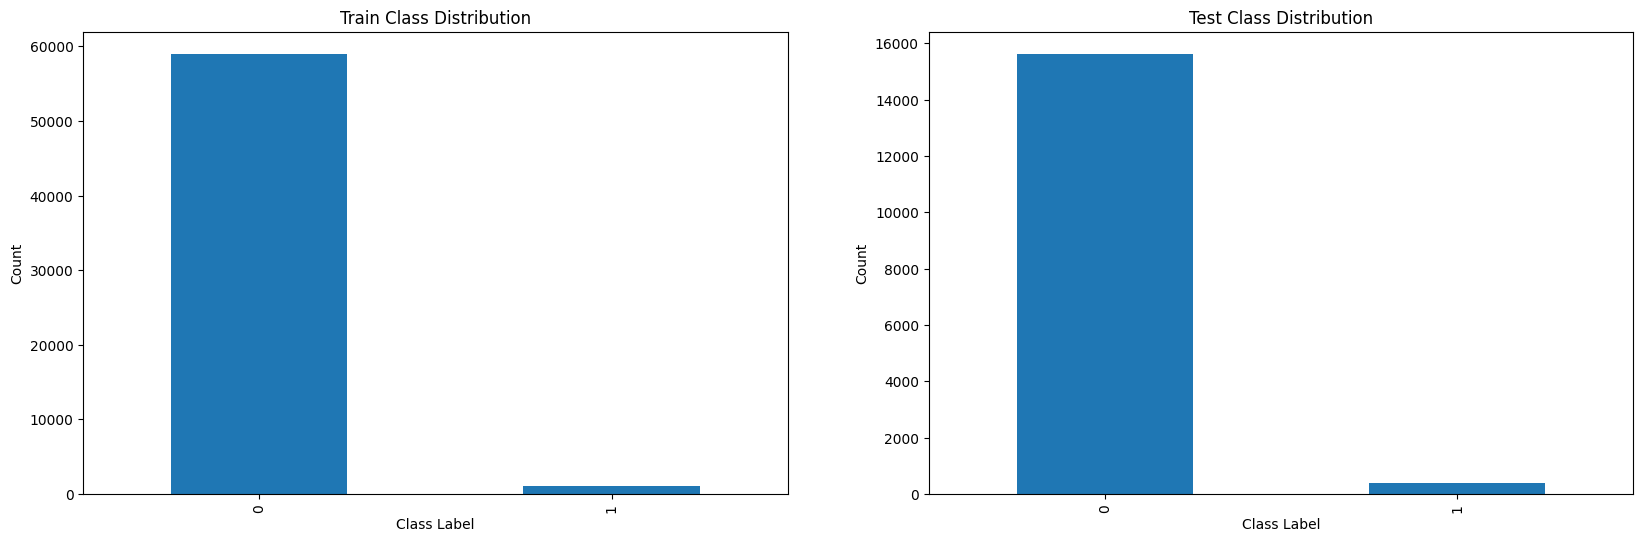

The number of train: 
Positive class = 1 points is:  1000
Negative class = 0 points is:  59000

The number of test: 
Positive class = 1 points is:  375
Negative class = 0 points is:  15625


In [59]:
# Plotting the distribution of class label
fig, axes = plt.subplots(figsize=(20,6),nrows=1, ncols=2)
train_filter2['class'].value_counts().plot(ax=axes[0], kind='bar',title='Train Class Distribution',xlabel='Class Label',ylabel='Count')
test_filter2['class'].value_counts().plot(ax=axes[1], kind='bar',title='Test Class Distribution',xlabel='Class Label',ylabel='Count');

plt.show()

print('The number of train: ')
print('Positive class = 1 points is: ',train_filter2['class'].value_counts()[1])
print('Negative class = 0 points is: ',train_filter2['class'].value_counts()[0])
print()
print('The number of test: ')
print('Positive class = 1 points is: ',test_filter2['class'].value_counts()[1])
print('Negative class = 0 points is: ',test_filter2['class'].value_counts()[0])


#### Observation
Both train and test dataset are highly imbalanced. Both has a very high number of negative class.

#### Notes : It is important to balancing the training data before build any model

In [17]:
# Upsampling minority class points, here minority class points are 1
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 2)
X_train_upsample, y_train_upsample = sm.fit_resample(train_filter2.drop(['class'],axis=1), train_filter2['class'])

print('After OverSampling, the shape of train_X: {}'.format(X_train_upsample.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_upsample.shape))
print("After OverSampling, train counts of label '1': {}".format(sum(y_train_upsample == 1)))
print("After OverSampling, train counts of label '0': {}".format(sum(y_train_upsample == 0)))


After OverSampling, the shape of train_X: (118000, 20)
After OverSampling, the shape of train_y: (118000,) 

After OverSampling, train counts of label '1': 59000
After OverSampling, train counts of label '0': 59000


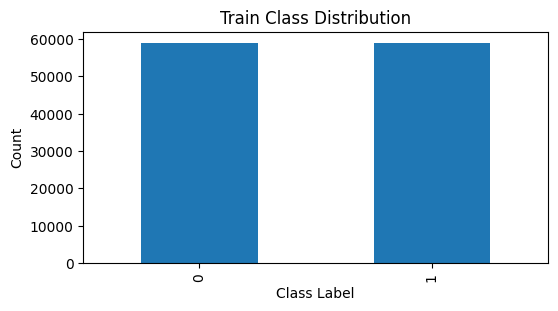

The number of train: 
Positive class = 1 points is:  59000
Negative class = 0 points is:  59000



In [131]:
# Plotting the distribution of class label
fig, axes = plt.subplots(figsize=(6,3),nrows=1, ncols=1)
y_train_upsample.value_counts().plot(ax=axes, kind='bar',title='Train Class Distribution',xlabel='Class Label',ylabel='Count')

plt.show()

print('The number of train: ')
print('Positive class = 1 points is: ',y_train_upsample.value_counts()[1])
print('Negative class = 0 points is: ',y_train_upsample.value_counts()[0])
print()

## Modelling

#### Feature scaling
A technique to standardize/normalize the range of independent variables or features of data. \
We will try both Standardization (StandardScaler) and Normalization (MinMaxScaler)

In [26]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from xgboost import XGBClassifier

In [19]:
# Normalizing data before splitting data and classification
# data_norm = StandardScaler().fit_transform(X_train_upsample) # Standardization (or z-score norm). Scale by std dev
data_norm = MinMaxScaler().fit_transform(X_train_upsample)  # Minmax scaling. Scale to range [min max]

# train test split (75%:25%)
X_train_norm, X_test_norm, y_train, y_test = train_test_split(data_norm, 
                                                              y_train_upsample, 
                                                              stratify=y_train_upsample, 
                                                              random_state=23)

print('X_train_norm: {}'.format(X_train_norm.shape))
print('y_train: {} \n'.format(y_train.shape))
print("X_test_norm: {}".format(X_test_norm.shape))
print("y_test: {}".format(y_test.shape))

X_train_norm: (88500, 20)
y_train: (88500,) 

X_test_norm: (29500, 20)
y_test: (29500,)


In [21]:
# Predictive data
y_prediction = test_filter2['class']
x_prediction = test_filter2.drop(['class'],axis=1)
x_pred_norm = MinMaxScaler().fit_transform(test_filter2.drop(['class'],axis=1)) # Standardization (or z-score norm). Scale by std dev


### Model 1 : Gradient Boosting

#### Train data : Upsampling data

In [17]:
#Classification using Gradient Boosting methods
gbc = GradientBoostingClassifier(n_estimators=10,random_state=0)
gbc.fit(X_train_upsample, y_train_upsample)

#Evaluating the performance of the Gradient Boosting algorithm and obtaining the cost
y_pred = gbc.predict(x_prediction)
report = classification_report(y_prediction, y_pred)
print(report)

cm = confusion_matrix(y_prediction, y_pred).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['tn', 'fp', 'fn', 'tp'])
total_cost = 10*cm.fp + 500*cm.fn
print(f'Cost_1 is: {float(cm.fp)}')
print(f'Cost_2 is: {float(cm.fn)}')
print(f'Total cost is: {float(total_cost.values[0])}')

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.30      0.97      0.45       375

    accuracy                           0.95     16000
   macro avg       0.65      0.95      0.71     16000
weighted avg       0.98      0.95      0.96     16000

Cost_1 is: 865.0
Cost_2 is: 13.0
Total cost is: 15150.0


#### Train data : Normalized data

In [22]:
#Classification using Gradient Boosting methods
gbc = GradientBoostingClassifier(n_estimators=10,random_state=0)
gbc.fit(X_train_norm, y_train)

#Evaluating the performance of the Gradient Boosting algorithm and obtaining the cost
y_pred = gbc.predict(x_pred_norm)
report = classification_report(y_prediction, y_pred)
print(report)

cm = confusion_matrix(y_prediction, y_pred).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['tn', 'fp', 'fn', 'tp'])
total_cost = 10*cm.fp + 500*cm.fn
print(f'Cost_1 is: {float(cm.fp)}')
print(f'Cost_2 is: {float(cm.fn)}')
print(f'Total cost is: {float(total_cost.values[0])}')

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     15625
           1       0.48      0.75      0.59       375

    accuracy                           0.98     16000
   macro avg       0.74      0.87      0.79     16000
weighted avg       0.98      0.98      0.98     16000

Cost_1 is: 300.0
Cost_2 is: 94.0
Total cost is: 50000.0


### Model 2 : Random Forest

#### Train data : Upsampling data

In [24]:
#Classificating using Random Forest
rfc = RandomForestClassifier(n_estimators= 1000 ,max_depth=10,n_jobs= -1)
rfc.fit(X_train_upsample, y_train_upsample)

#Evaluating the Random Forest Model
y_pred = rfc.predict(x_prediction)
report = classification_report(y_prediction, y_pred)
print(report)

cm = confusion_matrix(y_prediction, y_pred).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['tn', 'fp', 'fn', 'tp'])
total_cost = 10*cm.fp + 500*cm.fn
print(f'Cost_1 is: {float(cm.fp)}')
print(f'Cost_2 is: {float(cm.fn)}')
print(f'Total cost is: {float(total_cost.values[0])}')

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     15625
           1       0.41      0.93      0.57       375

    accuracy                           0.97     16000
   macro avg       0.70      0.95      0.78     16000
weighted avg       0.98      0.97      0.97     16000

Cost_1 is: 501.0
Cost_2 is: 26.0
Total cost is: 18010.0


#### Train data : Normalized data

In [23]:
#Classificating using Random Forest
rfc = RandomForestClassifier(n_estimators= 1000 ,max_depth=10,n_jobs= -1)
rfc.fit(X_train_norm, y_train)

#Evaluating the Random Forest Model
y_pred = rfc.predict(x_pred_norm)
report = classification_report(y_prediction, y_pred)
print(report)

cm = confusion_matrix(y_prediction, y_pred).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['tn', 'fp', 'fn', 'tp'])
total_cost = 10*cm.fp + 500*cm.fn
print(f'Cost_1 is: {float(cm.fp)}')
print(f'Cost_2 is: {float(cm.fn)}')
print(f'Total cost is: {float(total_cost.values[0])}')

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15625
           1       0.59      0.23      0.33       375

    accuracy                           0.98     16000
   macro avg       0.78      0.61      0.66     16000
weighted avg       0.97      0.98      0.97     16000

Cost_1 is: 61.0
Cost_2 is: 289.0
Total cost is: 145110.0


### Model 3 : KNN

#### Train data : Upsampling data

In [27]:
#Classification using K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_upsample, y_train_upsample)

#Evaluating the SVM model
y_pred = knn.predict(x_prediction)
report = classification_report(y_prediction, y_pred)
print(report)

cm = confusion_matrix(y_prediction, y_pred).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['tn', 'fp', 'fn', 'tp'])
total_cost = 10*cm.fp + 500*cm.fn
print(f'Cost_1 is: {float(cm.fp)}')
print(f'Cost_2 is: {float(cm.fn)}')
print(f'Total cost is: {float(total_cost.values[0])}')

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.36      0.86      0.51       375

    accuracy                           0.96     16000
   macro avg       0.68      0.91      0.74     16000
weighted avg       0.98      0.96      0.97     16000

Cost_1 is: 575.0
Cost_2 is: 54.0
Total cost is: 32750.0


#### Train data : Normalized data

In [29]:
#Classification using K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_norm, y_train)

#Evaluating the SVM model
y_pred = knn.predict(x_pred_norm)
report = classification_report(y_prediction, y_pred)
print(report)

cm = confusion_matrix(y_prediction, y_pred).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['tn', 'fp', 'fn', 'tp'])
total_cost = 10*cm.fp + 500*cm.fn
print(f'Cost_1 is: {float(cm.fp)}')
print(f'Cost_2 is: {float(cm.fn)}')
print(f'Total cost is: {float(total_cost.values[0])}')

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     15625
           1       0.40      0.63      0.49       375

    accuracy                           0.97     16000
   macro avg       0.70      0.80      0.74     16000
weighted avg       0.98      0.97      0.97     16000

Cost_1 is: 356.0
Cost_2 is: 138.0
Total cost is: 72560.0


### Model 4 : XGBoost

#### Train data : Upsampling data

In [23]:
#Classification using XGBoost
xgb = XGBClassifier()
xgb.fit(X_train_upsample, y_train_upsample)

#Evaluating 
y_pred = xgb.predict(x_prediction)
report = classification_report(y_prediction, y_pred)
print(report)

cm = confusion_matrix(y_prediction, y_pred).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['tn', 'fp', 'fn', 'tp'])
total_cost = 10*cm.fp + 500*cm.fn
print(f'Cost_1 is: {float(cm.fp)}')
print(f'Cost_2 is: {float(cm.fn)}')
print(f'Total cost is: {float(total_cost.values[0])}')

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15625
           1       0.47      0.87      0.61       375

    accuracy                           0.97     16000
   macro avg       0.73      0.92      0.80     16000
weighted avg       0.98      0.97      0.98     16000

Cost_1 is: 375.0
Cost_2 is: 48.0
Total cost is: 27750.0


#### Train data : Normalized data

In [24]:
#Classification using XGBoost
xgb = XGBClassifier()
xgb.fit(X_train_norm, y_train)

#Evaluating 
y_pred = xgb.predict(x_pred_norm)
report = classification_report(y_prediction, y_pred)
print(report)

cm = confusion_matrix(y_prediction, y_pred).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['tn', 'fp', 'fn', 'tp'])
total_cost = 10*cm.fp + 500*cm.fn
print(f'Cost_1 is: {float(cm.fp)}')
print(f'Cost_2 is: {float(cm.fn)}')
print(f'Total cost is: {float(total_cost.values[0])}')

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15625
           1       0.74      0.27      0.40       375

    accuracy                           0.98     16000
   macro avg       0.86      0.64      0.70     16000
weighted avg       0.98      0.98      0.98     16000

Cost_1 is: 36.0
Cost_2 is: 272.0
Total cost is: 136360.0


#### Summary

By comparing all models, Gradient Boosting with training upsampling data gives lower cost RM 15,510 than the other models.\
However, XGBoost showing the highest f1-score to predict positive class


#### Improvement
1. Applying PCA for dimension reduction 
2. Applying hyperparameter tuning (GridSearchCV)
3. Applying Cross Validation